In [19]:
from pathlib import Path
import pandas as pd
import xlwings as xw

In [20]:
INPUT_DIR = Path.cwd() / "reports" / "raw"
OUTPUT_DIR = Path.cwd() / "reports"

In [21]:
# workbook for output
summary_wb = xw.Book()
summary_sht = summary_wb.sheets[0]
summary_sht.name = "Summary"

In [ ]:
for file in INPUT_DIR.iterdir():
    if file.suffix == ".xlsx":
        wb = xw.Book(file)
        wb.app.display_alerts = False
        #wb.app.visible = False
        sht = wb.sheets("Overview")
        values = sht.range("B5").expand().copy()
        dest_last_row = summary_sht.range("A1").expand().last_cell.row + 1
        summary_sht.range(f"A{dest_last_row}").paste()
        wb.close()

In [ ]:
header = [
    "Segment",
    "Country",
    "Product",
    "Discount Band",
    "Units Sold",
    "Sale Price",
    "Gross Sales",
    "Discounts",
    "Sales",
    "COGS",
    "Profit",
]
header_row = summary_sht.range("A1:K1")
header_row.value = header
header_row.font.bold = True
header_row.font.color = (255, 255, 255)
header_row.color = (119, 136, 153)

In [24]:
df = summary_sht.range("A1").options(pd.DataFrame, expand="table").value
data_by_country = df.groupby(by="Country").sum()[["Sales"]]
data_by_country

,Sales
Country,
Canada,1.971177e+07
France,1.922138e+07
Germany,1.727761e+07
Japan,1.619493e+07
United States of America,1.990542e+07


In [25]:
summary_sht.range("M1").value = data_by_country

In [26]:
# charts
chart = summary_sht.charts.add(
    left=summary_sht.range("M8").left, 
    top=summary_sht.range("M8").top,
    width=400,
    height=200,
)
chart.set_source_data(summary_sht.range("M1").expand())
chart.chart_type = "bar_stacked"

<Picture 'Sales' in <Sheet [Book4]Summary>>

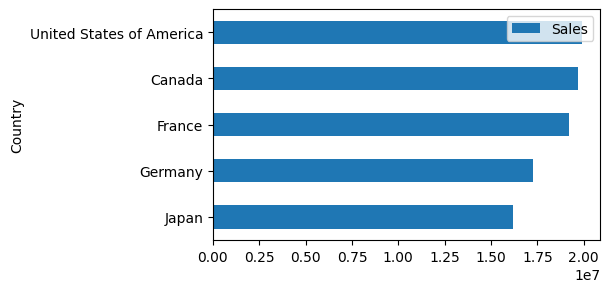

In [32]:

fig = plt.figure(figsize=(5, 3))
ax = data_by_country.sort_values(by="Sales").plot(kind="barh", ax=fig.gca())
fig.savefig("sales_plot.png", format="png")

summary_sht.pictures.add(
    "sales_plot.png",
    name="Sales",
    update=True,
    left=summary_sht.range("M23").left,
    top=summary_sht.range("M23").top,
    width=400,
    height=200,
)


In [33]:
summary_sht.autofit()
summary_wb.save(OUTPUT_DIR / "summary.xlsx")
if len(summary_wb.app.books) == 1:
    summary_wb.app.quit()
else:
    summary_wb.close()